In [97]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [70]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

print(f"tf version: {tf.__version__}")

tf version: 2.18.0


In [56]:
!nvidia-smi

Tue Oct 28 09:48:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [78]:
# try:
#     strategy = tf.distribute.MirroredStrategy()

#     NUM_REPLICAS = strategy.num_replicas_in_sync
#     print(f"Number of replicas (GPUs) in sync: {NUM_REPLICAS}")

# except Exception as e:
#     print(f"Error creating strategy: {e}")
#     strategy = tf.distribute.get_strategy()
#     NUM_REPLICAS = 1

Number of replicas (GPUs) in sync: 2


In [86]:
dir = '/kaggle/input/breast-histopathology-images'

image_path = glob.glob(os.path.join(dir, '*/*/*.png'))

data = []
for path in image_path:
    patient_id = path.split('/')[-3]
    label = int(path.split('/')[-2])
    
    data.append({
        'path': path,
        'patient_id': patient_id,
        'label': label
    })

df = pd.DataFrame(data)

print(f"Total images - {len(df)}")
print(f"Total patients - {df['patient_id'].nunique()}")
print(df['label'].value_counts())
print("\ndf head")
print(df.head())

Total images - 277524
Total patients - 279
label
0    198738
1     78786
Name: count, dtype: int64

df head
                                                path patient_id  label
0  /kaggle/input/breast-histopathology-images/102...      10295      0
1  /kaggle/input/breast-histopathology-images/102...      10295      0
2  /kaggle/input/breast-histopathology-images/102...      10295      0
3  /kaggle/input/breast-histopathology-images/102...      10295      0
4  /kaggle/input/breast-histopathology-images/102...      10295      0


In [87]:
patient_ids = df['patient_id'].unique()

np.random.seed(42)
np.random.shuffle(patient_ids)

# 80% train
# 10% validation
# 10% test
train_ratio = 0.8
val_ratio = 0.1

total_patients = len(patient_ids)
train_idx = int(total_patients * train_ratio)
val_idx = int(total_patients * (train_ratio + val_ratio))

train_patient_ids = patient_ids[:train_idx]
val_patient_ids = patient_ids[train_idx:val_idx]
test_patient_ids = patient_ids[val_idx:]

train_df = df[df['patient_id'].isin(train_patient_ids)]
val_df = df[df['patient_id'].isin(val_patient_ids)]
test_df = df[df['patient_id'].isin(test_patient_ids)]

print(f"Training - {len(train_df)} (from {len(train_patient_ids)} patients)")
print(f"Validation - {len(val_df)} (from {len(val_patient_ids)} patients)")
print(f"Test - {len(test_df)} (from {len(test_patient_ids)} patients)")

Training - 225545 (from 223 patients)
Validation - 27539 (from 28 patients)
Test - 24440 (from 28 patients)


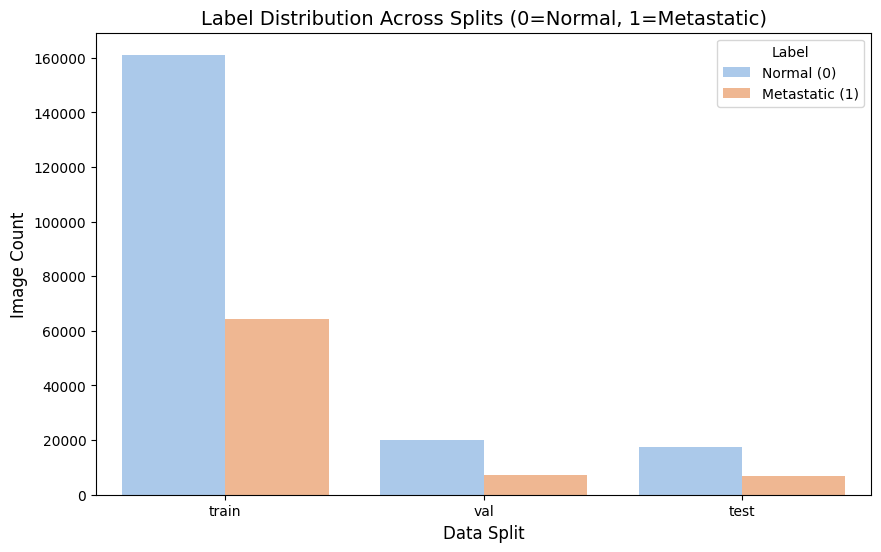

In [88]:
train_plot_df = train_df.copy()
val_plot_df = val_df.copy()
test_plot_df = test_df.copy()

train_plot_df['split'] = 'train'
val_plot_df['split'] = 'val'
test_plot_df['split'] = 'test'

# combine
full_df = pd.concat([train_plot_df, val_plot_df, test_plot_df])

plt.figure(figsize=(10, 6))
sns.countplot(data=full_df, x='split', hue='label', palette='pastel')
plt.title('Label Distribution Across Splits (0=Normal, 1=Metastatic)', fontsize=14)
plt.xlabel('Data Split', fontsize=12)
plt.ylabel('Image Count', fontsize=12)

plt.legend(title='Label', loc='upper right', labels=['Normal (0)', 'Metastatic (1)'])

plt.show()

In [90]:
IMG_SIZE = 96
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# read - dcode - resize - normalize
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0  
    return img, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

def create_dataset(df, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((df['path'], df['label']))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.shuffle(buffer_size=1024)
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = create_dataset(train_df, is_training=True)
val_ds = create_dataset(val_df, is_training=False)
test_ds = create_dataset(test_df, is_training=False)

print("\ndata pipelines created!!")


data pipelines created!!


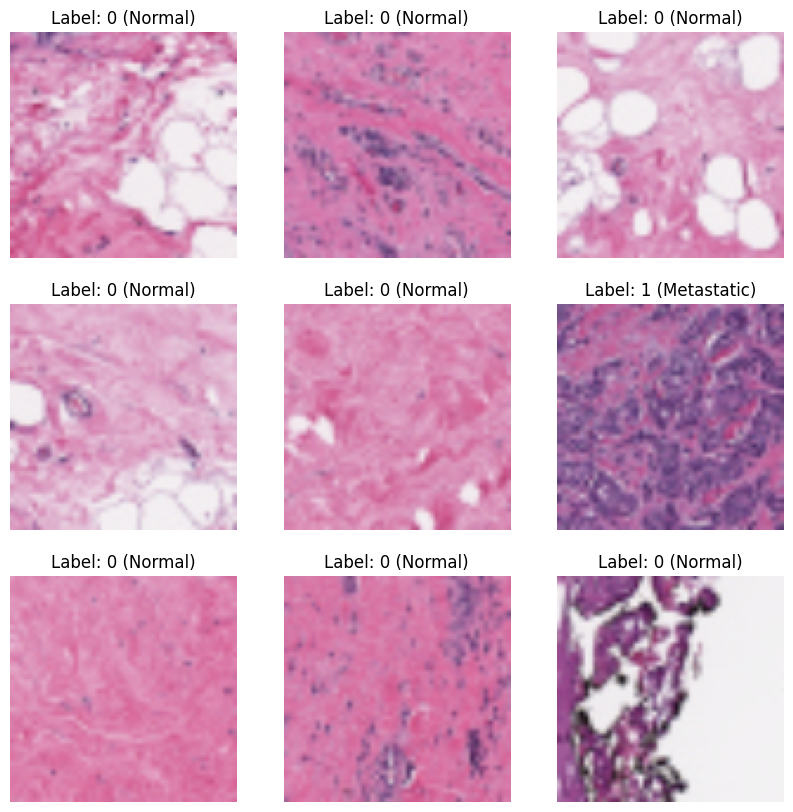

In [91]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label = labels[i].numpy()
        plt.title(f"Label: {label} ({'Metastatic' if label == 1 else 'Normal'})")
        plt.axis("off")

In [92]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
], name="data_augmentation")

base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')

base_model.trainable = False

inputs = Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x) 

model = Model(inputs, outputs)

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [93]:
# compile
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       AUC(name='auc'), 
                       Precision(name='precision'), 
                       Recall(name='recall')])

print("\nFeature Extraction-")
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)


Feature Extraction-
Epoch 1/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 253s 69ms/step - accuracy: 0.7227 - auc: 0.6153 - loss: 0.5823 - precision: 0.4783 - recall: 0.0630 - val_accuracy: 0.7321 - val_auc: 0.5072 - val_loss: 0.6022 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 240s 68ms/step - accuracy: 0.7249 - auc: 0.5795 - loss: 0.5790 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7321 - val_auc: 0.5262 - val_loss: 0.5963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 240s 68ms/step - accuracy: 0.7249 - auc: 0.5903 - loss: 0.5757 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7321 - val_auc: 0.5205 - val_loss: 0.5970 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 239s 68ms/step - accuracy: 0.7250 - auc: 0.6133 - loss: 0.5686 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7321 - val_auc: 0.5351 - val_loss:

In [95]:
base_model.trainable = True

# again with a very low learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', 'auc', 'precision', 'recall'])

print("\nFine-Tuning -")
fine_tune_epochs = 10
total_epochs = 5 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds
)


Fine-Tuning -
Epoch 5/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 954s 256ms/step - accuracy: 0.9098 - auc: 0.9602 - loss: 0.2233 - precision: 0.8513 - recall: 0.8120 - val_accuracy: 0.8808 - val_auc: 0.9419 - val_loss: 0.2795 - val_precision: 0.7568 - val_recall: 0.8175
Epoch 6/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 897s 254ms/step - accuracy: 0.9108 - auc: 0.9617 - loss: 0.2189 - precision: 0.8555 - recall: 0.8097 - val_accuracy: 0.8800 - val_auc: 0.9405 - val_loss: 0.2859 - val_precision: 0.7480 - val_recall: 0.8325
Epoch 7/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 898s 255ms/step - accuracy: 0.9130 - auc: 0.9632 - loss: 0.2137 - precision: 0.8589 - recall: 0.8140 - val_accuracy: 0.8741 - val_auc: 0.9398 - val_loss: 0.2955 - val_precision: 0.7260 - val_recall: 0.8510
Epoch 8/15
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 899s 255ms/step - accuracy: 0.9145 - auc: 0.9645 - loss: 0.2099 - precision: 0.8596 - recall: 0.8193 - val_accuracy: 0.8763 - val_auc: 0.9426 - val_loss: 0.2905 - val_precision: 0.7312 - val_recall: 

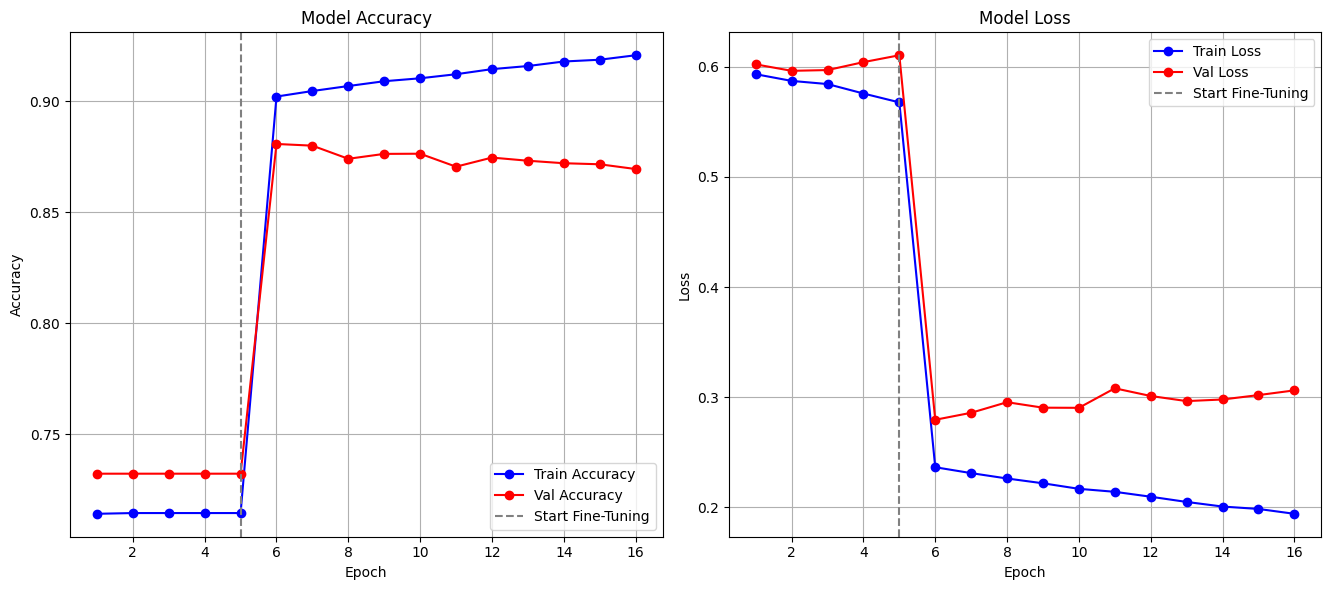

In [105]:
history_full = {}
for key in history.history.keys():
    history_full[key] = history.history[key] + history_fine.history[key]
    
history_df = pd.DataFrame(history_full)
history_df['epoch'] = range(1, len(history_df) + 1)

fine_tune_start_epoch = history.epoch[-1] + 1

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(history_df['epoch'], history_df['accuracy'], 'b-o', label='Train Accuracy')
plt.plot(history_df['epoch'], history_df['val_accuracy'], 'r-o', label='Val Accuracy')
plt.axvline(fine_tune_start_epoch, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history_df['epoch'], history_df['loss'], 'b-o', label='Train Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], 'r-o', label='Val Loss')
plt.axvline(fine_tune_start_epoch, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [96]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")
print(f"Test Precision: {results[3]}")
print(f"Test Recall: {results[4]}")

model.save("model.h5")
print("\nModel saved")

382/382 ━━━━━━━━━━━━━━━━━━━━ 60s 158ms/step - accuracy: 0.8709 - auc: 0.9274 - loss: 0.3048 - precision: 0.7666 - recall: 0.8113
Test Loss: 0.3145131766796112
Test Accuracy: 0.8722586035728455
Test AUC: 0.924540102481842
Test Precision: 0.7806648015975952
Test Recall: 0.769494891166687

Model saved


Done.


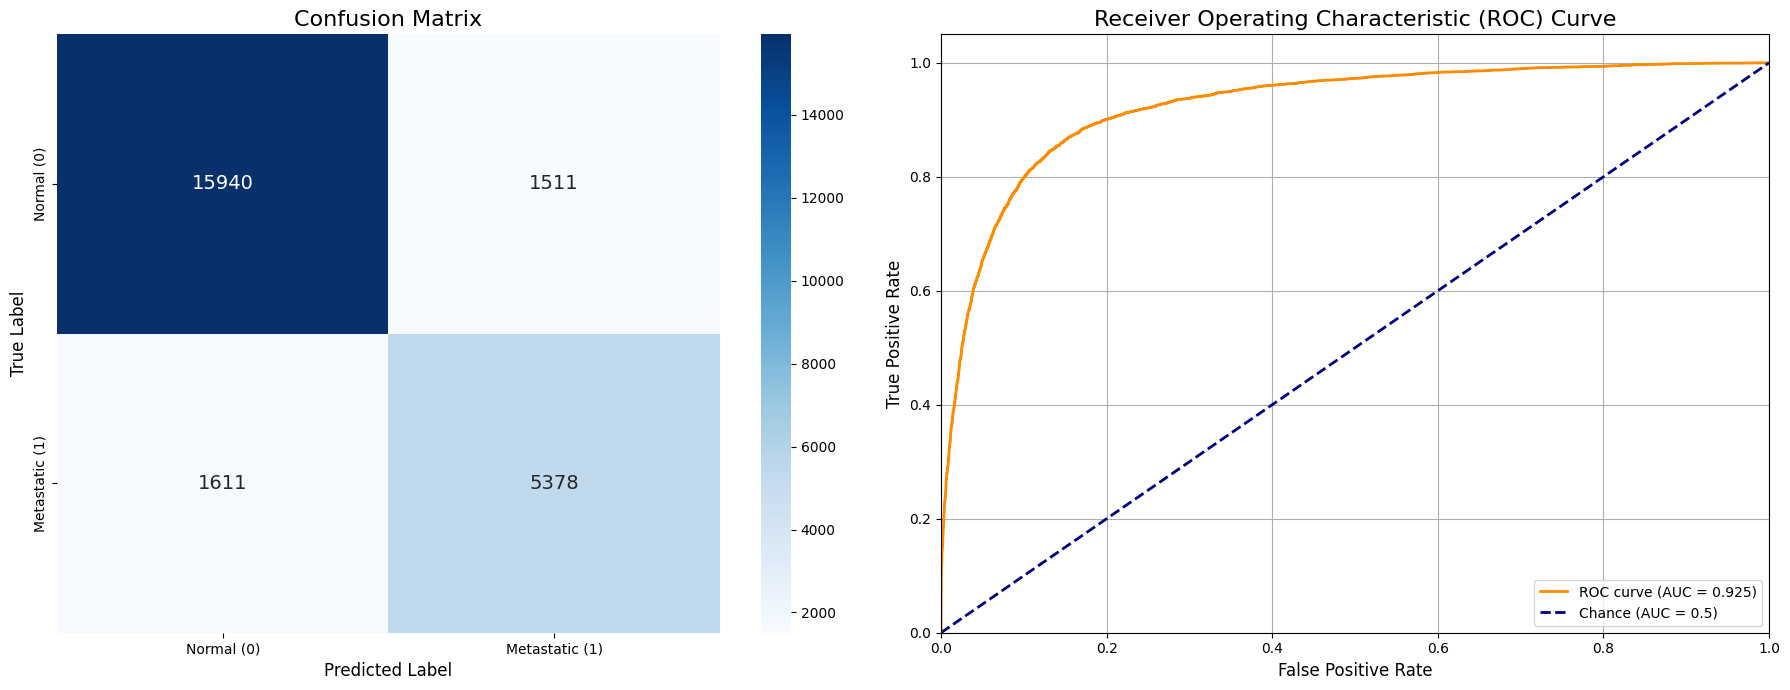

In [103]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs).flatten()
y_pred_classes = (y_pred_probs > 0.5).astype(int)
print("Done.")

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal (0)', 'Metastatic (1)'], 
            yticklabels=['Normal (0)', 'Metastatic (1)'],
            annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Plot ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:0.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

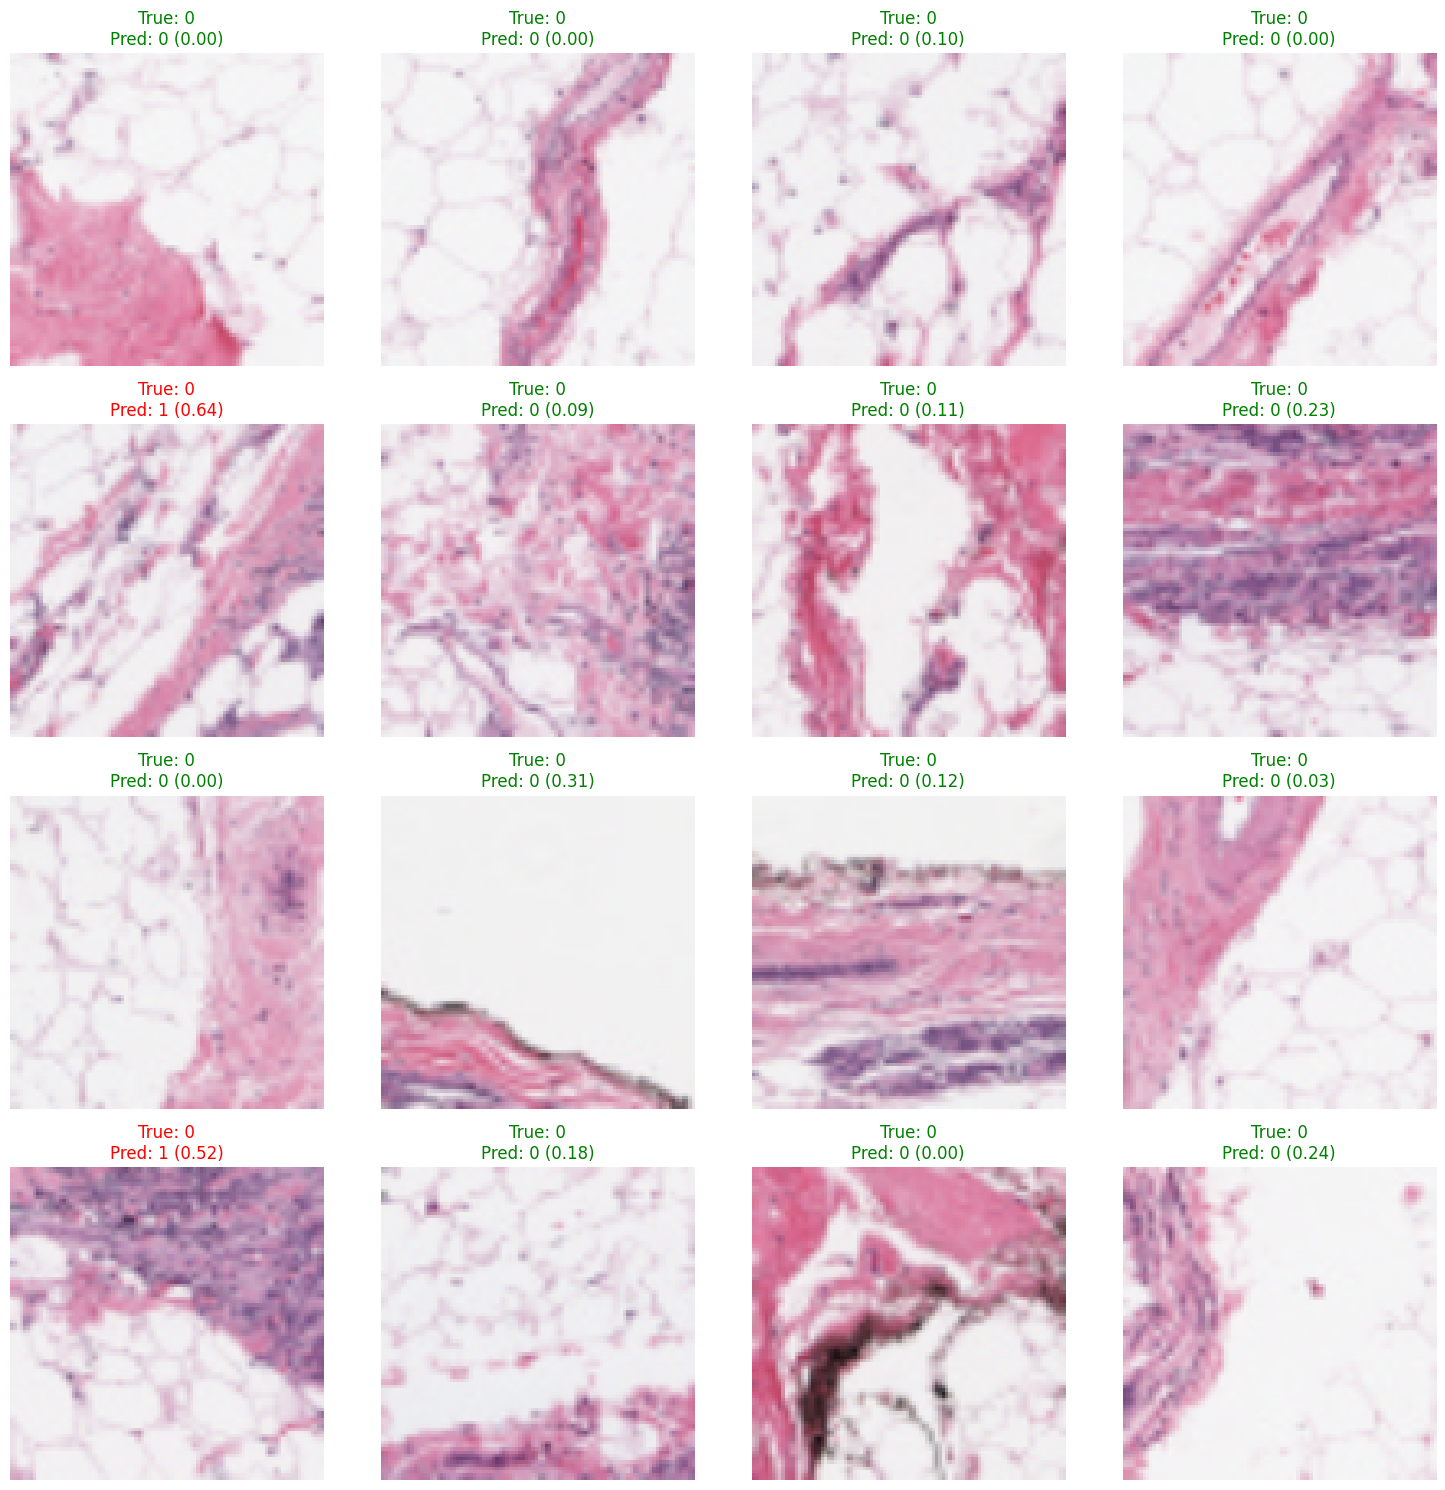

In [104]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    preds = model.predict(images, verbose=0).flatten()
    
    for i in range(min(16, len(labels))):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        
        true_label = int(labels[i].numpy())
        pred_prob = preds[i]
        pred_label = int(pred_prob > 0.5)
        
        color = 'green' if true_label == pred_label else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})", color=color, fontsize=12)
        plt.axis("off")

plt.tight_layout()
plt.show()